In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import time
from collections import defaultdict
from scipy.spatial import distance
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import ast
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/6240_project/project_data/

/content/drive/MyDrive/6240_project/project_data


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/6240_project/project_data/interactions_genres.csv')

In [ ]:
e = dict(zip(df['bid'],df['genres']))
book_g = pd.DataFrame()
book_g['bid'] = list(e.keys())
book_g['genres'] = list(e.values())
book_g.set_index('bid',inplace=True)

In [ ]:
book_g['genres'] = book_g['genres'].apply(lambda x : ast.literal_eval(x) )

In [ ]:
train_data, test_data = train_test_split(df,test_size=0.2)

In [ ]:
train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)

In [ ]:
user_indices = train_data['uid']

In [ ]:
item_indices = train_data['bid']

In [ ]:
ratings = train_data['rating']

In [ ]:
test_users = torch.LongTensor(test_data['uid'])
test_items = torch.LongTensor(test_data['bid'])
test_ratings = torch.LongTensor(test_data['rating'])

In [ ]:
from torch.utils.data import DataLoader, Dataset
class UserItemRatingDataset(Dataset):
    """Wrapper, convert <user, item, rating> Tensor into Pytorch Dataset"""
    def __init__(self, user_tensor, item_tensor, target_tensor):
        """
        args:
            target_tensor: torch.Tensor, the corresponding rating for <user, item> pair
        """
        self.user_tensor = user_tensor
        self.item_tensor = item_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.user_tensor[index], self.item_tensor[index], self.target_tensor[index]

    def __len__(self):
        return self.user_tensor.size(0)

In [ ]:
dataset = UserItemRatingDataset(user_tensor=torch.LongTensor(user_indices),
                                        item_tensor=torch.LongTensor(item_indices),
                                        target_tensor=torch.FloatTensor(ratings))
data_loader = DataLoader(dataset, batch_size=256, shuffle=True)

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # self.config = config
        # self.num_users = config['num_users']
        # self.num_items = config['num_items']
        # self.latent_dim = config['latent_dim']

        self.num_users = 267821
        self.num_items = 36182
        self.latent_dim = 32

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        config = {}
        config['layers'] = [74,32,16,8,8]
        self.output = nn.Linear(8,1)
        self.relu = nn.ReLU()
        
        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(config['layers'][:-1], config['layers'][1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        # self.affine_output = torch.nn.Linear(in_features=config['layers'][-1], out_features=1)
        # self.logistic = torch.nn.Sigmoid()


    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        genres_emb = torch.LongTensor(np.array(list(book_g.loc[item_indices.cpu().numpy()]['genres']))).cuda()
        # print(user_embedding.shape,item_embedding.shape,genres_emb.shape)
        vector = torch.cat([user_embedding, item_embedding,genres_emb], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = torch.nn.ReLU()(vector)
            # vector = torch.nn.BatchNorm1d()(vector)
            # vector = torch.nn.Dropout(p=0.5)(vector)
        
        # x = vector
        x = self.output(vector)
        output = self.relu(x)

        # logits = self.affine_output(vector)
        # rating = self.logistic(logits)
        # return rating
        return output


In [ ]:
!pip install torchinfo

In [ ]:
MLP_model = MLP()
# MLP_model.cuda()
from torchinfo import summary 
summary(MLP_model)

Layer (type:depth-idx)                   Param #
MLP                                      --
├─Embedding: 1-1                         8,570,272
├─Embedding: 1-2                         1,157,824
├─Linear: 1-3                            9
├─ReLU: 1-4                              --
├─ModuleList: 1-5                        --
│    └─Linear: 2-1                       2,400
│    └─Linear: 2-2                       528
│    └─Linear: 2-3                       136
│    └─Linear: 2-4                       72
Total params: 9,731,241
Trainable params: 9,731,241
Non-trainable params: 0

In [ ]:
MAE_list = []
MSE_list = []
RMSE_list = []

In [ ]:
assert torch.cuda.is_available(), 'CUDA is not available'
torch.cuda.set_device(0)

In [ ]:
def MLP_train(data_loader,MLP_model,test_users,test_items,test_ratings,epochs=15):
    """
    Arguments: 
    training_data (str-type numpy.array): the training data containing user_id, movie_id, and normalized rating (0-1) information.
    user_emb and item_emb (dictionaries of numpy.array): pre-trained embeddings of users and items. 
    - The keys are user_id (string) and item_id (string), and the values are the corresponding embeddings (numpy.array; dim=32) of user_id and item_id, respectively.
    MLP_model (MLP class): the untrained MLP model.
    epochs (int): number of iterations required for updating the MLP model.

    Returns:
    MLP_model (MLP class): the MLP model trained with given training data and pre-trained embeddings.

    Steps for the first code block:
    1. for each training example, retrieve pre-trained embeddings for a user u and item i.
    2. concatenate those embeddings by np.concatenate((user_emb_of_u,item_emb_of_i)) and append it to a list.
    3. convert a list of concatenated embeddings to a PyTorch FloatTensor by torch.FloatTensor(np.array(list)).
    """
    torch.manual_seed(0)
    np.random.seed(0)

    # input_data = torch.FloatTensor(np.array(l))

  #################################
  
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(MLP_model.parameters(),weight_decay = 0.001)

    for epoch in tqdm(range(epochs)):
        """  
    Steps for the second code block:
    1. set the gradients to zero before backpropragation by optimizer.zero_grad().
    2. call the prediction function of the MLP model by MLP_model(input_data).flatten() and obtain the prediction result for the input data, 
       where the input data is a PyTorch FloatTensor from Step 3 of the previous code block.
    3. obtain the ground-truth rating values from training_data (in torch.FloatTensor format; use torch.FloatTensor(np.array) for type conversion).
    4. compute the loss by loss=criterion(prediction,ground_truth).
    5. perform backpropragation by loss.backward().
    6. update the model parameters by optimizer.step().
    7. compute the differences between the prediction and ground_truth by (prediction-ground_truth).detach().numpy().
    8. compute and print training RMSE using the differences for every 10 epochs (epoch 0, epoch 10, ..., epoch 190).
        - Don't use loss in Step 4 to derive training RMSE 
        """
        optimizer.zero_grad()

        for batch_id, batch in enumerate(data_loader):
            # assert isinstance(batch[0], torch.LongTensor)
            # print(batch_id)
            user, item, rating = batch[0], batch[1], batch[2]
            user, item, rating = user.cuda(), item.cuda(), rating.cuda()
            # print(user.shape,rating.shape,item.shape)
            prediction = MLP_model(user,item).flatten()
            # ground_truth = torch.FloatTensor(training_data[:,2:].astype(np.float32).reshape(len(training_data)))
            ground_truth = rating.flatten()

            # print(prediction.shape,ground_truth.shape)
            
            loss = criterion(prediction,ground_truth)
            loss.backward()
            optimizer.step()

            diff = (prediction-ground_truth).detach().cpu().numpy()
            rmse = (np.mean(diff**2))**0.5

            abs_diff = np.absolute(diff)
            mae = np.mean(abs_diff)
            if batch_id % 500 == 0:
            # # if epoch % 10 == 0:
              print("rmse:", rmse, "mse:",loss, "mae:",mae)
              # MAE_list.append(mae)
              # MSE_list.append(loss)
              # RMSE_list.append(rmse)
      
        test_users, test_items, test_ratings = test_users.cuda(), test_items.cuda(), test_ratings.cuda()
        test_preds = MLP_model(test_users,test_items).flatten()

        diff = (test_preds-test_ratings).detach().cpu().numpy()
        rmse = (np.mean(diff**2))**0.5

        abs_diff = np.absolute(diff)
        mae = np.mean(abs_diff)
        
        print("test_metrics........","rmse:", rmse, "mse:",loss, "mae:",mae)
        MAE_list.append(mae)
        MSE_list.append(loss)
        RMSE_list.append(rmse)


            
    #################################
    return MLP_model

In [ ]:
trained_MLP_model = MLP_train(data_loader,MLP_model,test_users,test_items,test_ratings)

  0%|          | 0/15 [00:00<?, ?it/s]

rmse: 3.9850909618301134 mse: tensor(15.8809, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 3.687871
rmse: 4.160609432842878 mse: tensor(17.3107, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 4.039714
rmse: 3.2716146779087554 mse: tensor(10.7035, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 3.1105523
rmse: 2.240801233147061 mse: tensor(5.0212, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 2.0489876
rmse: 1.6376016279526497 mse: tensor(2.6817, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 1.4168104
rmse: 1.1766266682466187 mse: tensor(1.3845, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.9758432
rmse: 0.962838718957439 mse: tensor(0.9271, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7776071
rmse: 1.296094222755645 mse: tensor(1.6799, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.9658669


  7%|▋         | 1/15 [00:36<08:32, 36.61s/it]

test_metrics........ rmse: 2.6943798275919586 mse: tensor(6.8708, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 2.0804443
rmse: 2.6161001195501394 mse: tensor(6.8440, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 2.0556607
rmse: 1.454933190008079 mse: tensor(2.1168, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 1.0610085
rmse: 1.3129144649957283 mse: tensor(1.7237, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.9256372
rmse: 1.0592699882200598 mse: tensor(1.1221, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8191689
rmse: 0.9059569115087133 mse: tensor(0.8208, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.6988278
rmse: 1.0782722704272625 mse: tensor(1.1627, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.94814575
rmse: 1.3141359397151984 mse: tensor(1.7270, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 1.1443872
rmse: 1.5267249997973125 mse: tensor(2.3309, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 1.3228961


 13%|█▎        | 2/15 [01:09<07:29, 34.57s/it]

test_metrics........ rmse: 1.5953249162121657 mse: tensor(2.5981, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 1.403802
rmse: 1.5409705248519598 mse: tensor(2.3746, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 1.3481011
rmse: 1.410944837042065 mse: tensor(1.9908, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 1.1943624
rmse: 1.062162065058358 mse: tensor(1.1282, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.93098176
rmse: 0.966561213584066 mse: tensor(0.9342, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.74259067
rmse: 1.0529096524712316 mse: tensor(1.1086, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8028778
rmse: 1.346567438328581 mse: tensor(1.8132, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.9707699
rmse: 1.491982810476244 mse: tensor(2.2260, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 1.1702393
rmse: 1.4126165173165088 mse: tensor(1.9955, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.9568968


 20%|██        | 3/15 [01:43<06:47, 33.98s/it]

test_metrics........ rmse: 1.1467516196093734 mse: tensor(1.0309, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.878071
rmse: 0.9995769559575429 mse: tensor(0.9992, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.76023245
rmse: 1.102983140334125 mse: tensor(1.2166, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8840738
rmse: 1.0125750007637118 mse: tensor(1.0253, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8237953
rmse: 1.0760451448180617 mse: tensor(1.1579, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.92614603
rmse: 1.1862026958460026 mse: tensor(1.4071, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 1.0433195
rmse: 1.0983363315230699 mse: tensor(1.2063, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.96405804
rmse: 0.9832013111605488 mse: tensor(0.9667, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.77843326
rmse: 1.0482341427011903 mse: tensor(1.0988, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.82439405


 27%|██▋       | 4/15 [02:17<06:14, 34.07s/it]

test_metrics........ rmse: 1.1816265515206597 mse: tensor(1.4448, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8901719
rmse: 1.2773949382452945 mse: tensor(1.6317, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.9411154
rmse: 1.0056545011888594 mse: tensor(1.0113, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.82416284
rmse: 1.0363004298990284 mse: tensor(1.0739, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8749772
rmse: 1.1782988908168244 mse: tensor(1.3884, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 1.0434651
rmse: 1.0981798653962747 mse: tensor(1.2060, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.97021985
rmse: 0.9639179869524824 mse: tensor(0.9291, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.78589654
rmse: 1.1390585398245416 mse: tensor(1.2975, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.89355266
rmse: 1.0416053118120572 mse: tensor(1.0849, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.84237623


 33%|███▎      | 5/15 [02:50<05:38, 33.82s/it]

test_metrics........ rmse: 0.9791324217198614 mse: tensor(0.8899, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7657892
rmse: 0.9635474883582398 mse: tensor(0.9284, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.72475135
rmse: 1.0463491798890932 mse: tensor(1.0948, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8362876
rmse: 1.0522032691401568 mse: tensor(1.1071, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8264926
rmse: 1.0377905381385035 mse: tensor(1.0770, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7746204
rmse: 0.970768609706799 mse: tensor(0.9424, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.79434264
rmse: 0.8918281258961134 mse: tensor(0.7954, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.6912093
rmse: 0.9422574449074523 mse: tensor(0.8878, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.732622
rmse: 1.0183155514235842 mse: tensor(1.0370, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8176764


 40%|████      | 6/15 [03:23<05:02, 33.63s/it]

test_metrics........ rmse: 0.9793293324079991 mse: tensor(0.9831, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7624251
rmse: 0.9786037626185179 mse: tensor(0.9577, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7344341
rmse: 1.0087007851394982 mse: tensor(1.0175, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7789206
rmse: 0.9540981265331235 mse: tensor(0.9103, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.74593294
rmse: 0.9057382914760058 mse: tensor(0.8204, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7500336
rmse: 0.9532401843902473 mse: tensor(0.9087, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.756817
rmse: 1.0000129937281426 mse: tensor(1.0000, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7756257
rmse: 1.0050561160462521 mse: tensor(1.0101, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8300762
rmse: 0.9724994824170302 mse: tensor(0.9458, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.75351435


 47%|████▋     | 7/15 [03:57<04:28, 33.50s/it]

test_metrics........ rmse: 0.9799235374438406 mse: tensor(0.9920, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7587331
rmse: 0.9623625818222576 mse: tensor(0.9261, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.74480444
rmse: 1.0056862098742945 mse: tensor(1.0114, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.77327037
rmse: 1.024261492339994 mse: tensor(1.0491, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8267973
rmse: 0.9664378723053029 mse: tensor(0.9340, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7589617
rmse: 1.0029268348304123 mse: tensor(1.0059, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7900748
rmse: 1.0119307012465657 mse: tensor(1.0240, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.82696396
rmse: 0.9840948523651255 mse: tensor(0.9684, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8196289
rmse: 0.9961525693992316 mse: tensor(0.9923, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7719387


 53%|█████▎    | 8/15 [04:30<03:54, 33.43s/it]

test_metrics........ rmse: 0.9794135932158999 mse: tensor(1.2502, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7617102
rmse: 1.0183733799786767 mse: tensor(1.0371, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7758337
rmse: 0.9942049256760066 mse: tensor(0.9884, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7792784
rmse: 1.000716429613084 mse: tensor(1.0014, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.78050536
rmse: 0.8828297166073905 mse: tensor(0.7794, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.6868967
rmse: 0.9155305338486088 mse: tensor(0.8382, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.73465204
rmse: 1.005484857556154 mse: tensor(1.0110, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.78531134
rmse: 0.9467225710610244 mse: tensor(0.8963, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7484442
rmse: 1.0793305443210708 mse: tensor(1.1650, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8577386


 60%|██████    | 9/15 [05:03<03:20, 33.34s/it]

test_metrics........ rmse: 0.9813151866374841 mse: tensor(0.7276, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7594071
rmse: 0.9529732755374359 mse: tensor(0.9082, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7618812
rmse: 1.0271463530875289 mse: tensor(1.0550, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.80133593
rmse: 1.0384496731637252 mse: tensor(1.0784, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.83606094
rmse: 0.9989583133118077 mse: tensor(0.9979, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.78621817
rmse: 1.0213254144808128 mse: tensor(1.0431, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.82101274
rmse: 1.0489274018824473 mse: tensor(1.1002, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8640112
rmse: 1.0263890228707298 mse: tensor(1.0535, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.85674906
rmse: 1.0135766133435318 mse: tensor(1.0273, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.84426165


 67%|██████▋   | 10/15 [05:36<02:46, 33.32s/it]

test_metrics........ rmse: 0.9953643222414803 mse: tensor(1.0420, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8132308
rmse: 1.0504273453234854 mse: tensor(1.1034, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.87759113
rmse: 1.0280014659559433 mse: tensor(1.0568, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.81684947
rmse: 0.93345299461743 mse: tensor(0.8713, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.69244146
rmse: 0.9822749792133123 mse: tensor(0.9649, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7730112
rmse: 0.9817922406008671 mse: tensor(0.9639, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7895938
rmse: 0.9290666510691005 mse: tensor(0.8632, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7802771
rmse: 0.8995074328273952 mse: tensor(0.8091, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7426006
rmse: 0.9737430613396643 mse: tensor(0.9482, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.76603985


 73%|███████▎  | 11/15 [06:10<02:13, 33.30s/it]

test_metrics........ rmse: 0.9945843199229744 mse: tensor(1.1665, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7988756
rmse: 0.9513434034149608 mse: tensor(0.9051, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7843907
rmse: 1.0487675995651486 mse: tensor(1.0999, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8563707
rmse: 0.9843069083263106 mse: tensor(0.9689, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.79586995
rmse: 0.9486815891052826 mse: tensor(0.9000, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.75618136
rmse: 0.9223168817322868 mse: tensor(0.8507, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.74850464
rmse: 1.1169419452262224 mse: tensor(1.2476, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.87649393
rmse: 0.905510337473579 mse: tensor(0.8199, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7492792
rmse: 0.9585560698747781 mse: tensor(0.9188, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7675297


 80%|████████  | 12/15 [06:43<01:39, 33.24s/it]

test_metrics........ rmse: 0.9825325329080234 mse: tensor(0.9690, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.76710635
rmse: 1.00980139545413 mse: tensor(1.0197, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7855694
rmse: 0.9421621429928143 mse: tensor(0.8877, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.77143973
rmse: 0.9912374558683307 mse: tensor(0.9826, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7923703
rmse: 1.0115236072057687 mse: tensor(1.0232, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.82681906
rmse: 1.0025696521449463 mse: tensor(1.0051, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8058925
rmse: 1.0338885912540898 mse: tensor(1.0689, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.85279167
rmse: 0.9565963691266074 mse: tensor(0.9151, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.77320635
rmse: 1.0213474743572113 mse: tensor(1.0432, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8348946


 87%|████████▋ | 13/15 [07:16<01:06, 33.25s/it]

test_metrics........ rmse: 1.0072188883976003 mse: tensor(1.1568, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8104201
rmse: 1.0437847474304776 mse: tensor(1.0895, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.83461803
rmse: 1.0145953314122027 mse: tensor(1.0294, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.84800386
rmse: 0.9822008555490709 mse: tensor(0.9647, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7792621
rmse: 0.9700959607469543 mse: tensor(0.9411, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.81255794
rmse: 0.9415031161669488 mse: tensor(0.8864, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.78826106
rmse: 1.0335685790349662 mse: tensor(1.0683, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.848966
rmse: 1.016514549965591 mse: tensor(1.0333, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.79966205
rmse: 1.0270517608762681 mse: tensor(1.0548, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.83422816


 93%|█████████▎| 14/15 [07:49<00:33, 33.26s/it]

test_metrics........ rmse: 0.9794792258107677 mse: tensor(0.9562, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7612249
rmse: 1.0368299089759587 mse: tensor(1.0750, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8105261
rmse: 0.9577686505136023 mse: tensor(0.9173, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.74584836
rmse: 1.0010561134547635 mse: tensor(1.0021, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.8086383
rmse: 0.8904976335437309 mse: tensor(0.7930, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.6943359
rmse: 0.970736527971561 mse: tensor(0.9423, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7675477
rmse: 0.9870643209932021 mse: tensor(0.9743, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.7513422
rmse: 0.9810266920982749 mse: tensor(0.9624, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.773546
rmse: 0.9859374830726586 mse: tensor(0.9721, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.767733


100%|██████████| 15/15 [08:22<00:00, 33.53s/it]

test_metrics........ rmse: 0.9818417483890669 mse: tensor(0.9515, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.779797


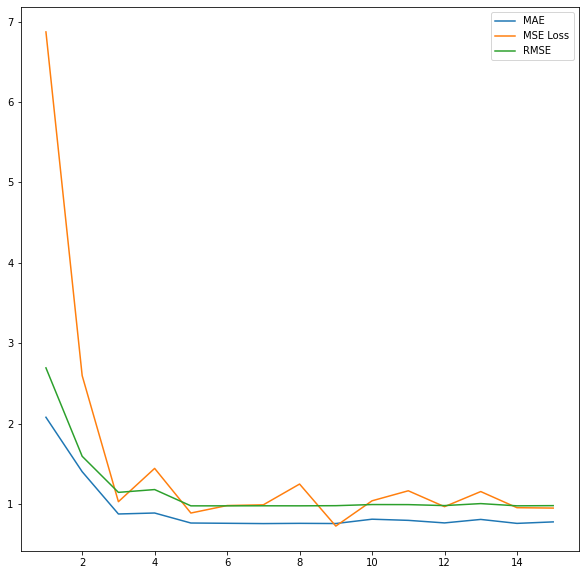

In [ ]:

MSE_list = [c.cpu().detach().numpy() for c in MSE_list]
plt.figure(figsize=(10,10))
x = list(range(1,(len(MAE_list)+1))) 
plt.plot(x,MAE_list,label='MAE')
plt.plot(x,MSE_list,label='MSE Loss')
plt.plot(x,RMSE_list,label='RMSE')
plt.legend()
# plt.show()
plt.savefig('ncf_32_genres_1.png')

In [ ]:
torch.save(trained_MLP_model,'/content/drive/MyDrive/6240_project/project_data/ncf_model_32_genres_1')

In [ ]:
# 64 test_metrics........ rmse: 0.9887338438775779 mse: tensor(0.9542, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.79190356
# 32  test_metrics........ rmse: 0.9818417483890669 mse: tensor(0.9515, device='cuda:0', grad_fn=<MseLossBackward0>) mae: 0.779797